In [1]:
import sys
sys.path.insert(1,'/home/bwhiteak/ChaosESN/ESN_utils/')

import numpy as np
import torch
import rc_tools as rct
import rc_analysis as rca
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.optimize import fsolve
from scipy.signal import argrelextrema
import sys
import warnings
import time

import pdb

from skopt.space import Real,Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

import signalz

import warnings
warnings.filterwarnings("ignore")

from jupyterthemes import jtplot
jtplot.style()

np.random.seed(11)
torch.set_printoptions(precision=10)
dtype = torch.float32 

print(f'Python: {sys.version}')
print(f'Numpy: {np.__version__}')
print(f'Torch: {torch.__version__}')

DEVICE = 'cuda:0'

FREERUN = 1000
Ns = 20000+FREERUN
signal = signalz.mackey_glass(Ns, a=0.2, b=0.8, c=0.9, d=23, e=10, initial=0.1)
signal = signal - np.mean(signal)
print(f'\nsignal mean={np.mean(signal)}')
M = signal.shape[0]-FREERUN
K = 1
L = 1
RF = .5
TEST = 300
LEAD = 100
BURNIN = 100
REG = 1e-8
TRAINLENGTH = M-TEST


MINMAX = np.max(signal[:TRAINLENGTH+TEST]) - np.min(signal[:TRAINLENGTH+TEST])
BINS = 50

print(f'Signal Length M={M}')
print(f'minmax={MINMAX}')

Python: 3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0]
Numpy: 1.21.2
Torch: 1.10.0

signal mean=-6.580979147873308e-17
Signal Length M=20000
minmax=1.611402028919085


In [2]:
def get_weight_matricesGPU(k,n,l,ri,ro):
    win = torch.rand((n,k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ri)
    wfb = torch.zeros((n,l),dtype=dtype, device=torch.device(DEVICE))
    wout = torch.rand((l,n+k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ro)
    return win, wfb, wout

def set_vectorsGPU(n,l,r):
    x0 = torch.rand((n,1),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(r)
    y0 = torch.zeros((l,1),dtype=dtype, device=torch.device(DEVICE))
    return x0, y0

def update_res_stateGPU(wnet,xt,uxy,a,g):
    z = torch.matmul(wnet,uxy)
    return torch.mul(xt,1-a) + torch.mul(torch.tanh(z),a*g)

def predict_yGPU(wout,xu):
    return torch.matmul(wout, xu)

def get_matrixGPU(n,r,sr):
    A = (torch.rand((n,n),dtype=dtype,
                   device=torch.device(DEVICE))-.5)*r
    At = torch.transpose(A,0,1)
    D = torch.diag(torch.diag(A))   
    W = A + At - D
    eig = torch.eig(W, eigenvectors=False)
    wsr = torch.max(torch.abs(eig[0]))
    return W.div(wsr).mul(sr)

def resize_spaces(mn, mx, best, isAlpha=False):
    #pdb.set_trace()
    if(best.size==0):
        new_mn = np.max([0, mn - .5*mn])
        new_mx = 1.5*mx
    else:
        best_mn = np.min(best)
        best_mx = np.max(best)
        mn_bound = (best_mn-mn)/2
        mx_bound = (mx -best_mx)/2
        new_mn, new_mx = best_mn-mn_bound, best_mx+mx_bound
        print(f'\nBest mn:{best_mn:.3f}\t mn:{best_mx:.3f}')
        print(f'New bounds mn--mx: {mn_bound:.3f}--{mx_bound:.3f}')
    if(isAlpha):
        if(new_mx>1):
            new_mx = 1
    
    return new_mn, new_mx

In [3]:
min_a, max_a = .2,.8      # .2, .4
min_sr, max_sr = 5,6.5   # 5., 6.5
min_g, max_g = .2, .4     # .2, .4
min_ri, max_ri = .4, .7   # .001, 5.
min_rr, max_rr = 2, 3 # .001, 5.
space = [Real(min_a, max_a, name='a'),
                 Real(min_sr, max_sr, name='sr'),
                 Real(min_g, max_g, name='amp'), 
                 Real(min_ri, max_ri, name='ri'),
                 Real(min_rr, max_rr, name='rr')
                ]

@use_named_args(space)
def loop(a=1.0,sr=1.0,amp=1.0,ri=1.0,rr=1.0):
    start = time.time()
    global running_error, s, signal, counter, N, ref, rn, \
           alphas, rhos, gammas, inScales, resScales
    
    ut = torch.zeros((1,1),dtype=dtype,
                     device=torch.device(DEVICE))
    tp = torch.zeros((1,1),dtype=dtype,
                     device=torch.device(DEVICE))
    
    Wres = get_matrixGPU(N,rr,sr)
    Win, Wfb, Wout = get_weight_matricesGPU(K,N,L,ri,RF)
    Wnet = torch.cat((Win,Wres,Wfb),1)
    xt, yt = set_vectorsGPU(N,L,rr)

    states = torch.zeros((TRAINLENGTH, N+K),dtype=dtype,
                         device=DEVICE)
    targets = torch.zeros((TRAINLENGTH),dtype=dtype,
                         device=DEVICE)
    for i in range(TRAINLENGTH):
        ut[0,0] = s[i]
        tp[0,0] = s[i+1]
        targets[i] = s[i+1]
        uxy = torch.cat((ut,xt,yt),0)
        xt1 = update_res_stateGPU(Wnet,xt,uxy,a,amp)
        xu = torch.transpose(torch.cat((xt1,ut),0),0,1).to(DEVICE)
        states[i,:] = xu[0,:]
        xt, yt = xt1, tp 
        
    state = states.detach().cpu().numpy()

    torch.cuda.synchronize()
    wout = rct.get_trained_weights(state[BURNIN:],
                                   signal[BURNIN+1:TRAINLENGTH+1],
                                   REG)
    Wout = torch.from_numpy(wout.reshape(L,N+K)).type(dtype).cuda(DEVICE)
    torch.cuda.synchronize()

    predictions = torch.zeros((M+FREERUN,1),
                              dtype=dtype,
                              device=torch.device(DEVICE))

    xt, yt = set_vectorsGPU(N,L,rr)
    ut.fill_(0.0)
    for i in range(M+FREERUN):
        if(i < TRAINLENGTH):
            ut[0,0] = s[i]
        else:
            ut = yt
        uxy = torch.cat((ut,xt,yt),0)
        xt1 = update_res_stateGPU(Wnet,xt,uxy,a,amp)
        xu = torch.cat((xt1,ut),0)
        yt1 = predict_yGPU(Wout,xu)
        predictions[i] = yt1[0,0]
        xt, yt = xt1, yt1

    yHat_GPU = predictions.detach().cpu().numpy()
    
    nrmse = 1000.0
    try:
        nrmse = rca.NRMSE(signal[TRAINLENGTH:TRAINLENGTH+TEST],
                          yHat_GPU[TRAINLENGTH:TRAINLENGTH+TEST],
                          MINMAX) 
    except:
        pass
        
    
    av = signal[TRAINLENGTH:TRAINLENGTH+TEST].reshape(TEST,1)
    bv = np.squeeze(yHat_GPU[TRAINLENGTH:TRAINLENGTH+TEST]).reshape(TEST,1)
    num = np.squeeze(np.dot(av.T,bv))
    den = np.linalg.norm(av)*np.linalg.norm(bv)
    cosine_similarity = num/den
    cosine_distance = 1 - cosine_similarity
    dist = cosine_distance
    
    loss = nrmse + dist
    if(np.isnan(loss) or (np.isinf(loss) or (loss > 1000.0))):
        loss = 1000

    if((loss < running_error) & (loss < .3)):
        alphas.append(a)
        rhos.append(sr)
        gammas.append(amp)
        inScales.append(ri)
        resScales.append(rr)
        running_error = loss
        wnet = Wnet.detach().cpu().numpy()
        currentParams = np.array([a,sr,amp,ri,rr,loss])
        
        fig = plt.figure(figsize=(10,8))
        ax1 = plt.subplot(111)
        ax1.plot(signal[TRAINLENGTH-LEAD:], label='Target')
        ax1.plot(yHat_GPU[TRAINLENGTH-LEAD:], label='GPU')
        ax1.axvline(LEAD,c='orange',linestyle='dashed')
        ax1.axvline(LEAD+TEST,c='r',linestyle='dashed')
        ax1.set_ylim(-2,2)
        ax1.legend()
        plt.show()
        fig.savefig(f'./MG_Saved_Models/MG_sz{N}_ref{ref}_run{rn}_iter{counter}.pdf',
                    format='pdf', bbox_inches='tight', pad_inches=.01)
        plt.close()
        
        np.save(f'./MG_Saved_Models/MG_it{counter}_{N}_{ref}_{rn}_Wnet',wnet)
        np.save(f'./MG_Saved_Models/MG_it{counter}_{N}_{ref}_{rn}_Preds',yHat_GPU)
        np.save(f'./MG_Saved_Models/MG_it{counter}_{N}_{ref}_{rn}_InstanceParams',currentParams)  
        print(f' Ref {ref} Run {rn} Iter={counter} a={a:.3f} sr={sr:.3f} amp={amp:.3f}',
              f' ri={ri:.3f} rr={rr:.3f} loss={loss:3f}\n\n')
    
    print(f'Iter: {counter} #### Diagnostic {loss:.3f}   Time {(time.time()-start):.2f}',
          f' Best {running_error:.3f} NRMSE {nrmse:.3f} CD {dist:.3f}')
    
    counter += 1
    return loss

tols = [1/10**x for x in range(0,20)]
SIGNUM = 2 # MG
itr = 41
sz = 1000
ref = 0
run = 0

p = np.load(f'../MG_Saved_Models/MG_it{itr}_{sz}_{ref}_{run}_Preds.npy', allow_pickle=True)
Wr, Wi = rca.get_mats(f'../MG_Saved_Models/MG_it{itr}_{sz}_{ref}_{run}_Wnet.npy',K,sz)
#Wr = Wr/np.max(np.abs(np.linalg.eigvals(Wr)))
a,g = p[0],p[2]
x0 = np.zeros((sz,1))
u0 = np.zeros((K,1))
A = rca.leaky_jacobian(x0, u0, a, g, Wi, Wr)
B = rca.partial_u(x0, u0, a, g, Wi, Wr)
Cn = rca.reachable_matrix(A,B)
nan_flag = np.isnan(Cn).any()
inf_flag = np.isinf(Cn).any()
print(f'NaN present {nan_flag}\t inf present {inf_flag}\n')
Cn = np.nan_to_num(rca.reachable_matrix(A,B), nan=1)
if(SIGNUM != 3): # Square Cn
    Cn = Cn/np.abs(np.max(np.linalg.eigvals(Cn)))
else:            # Non-square Cn
    Cn = Cn/np.abs(np.max(np.linalg.svd(Cn, compute_uv=False)))

rkc = rank_curve(Cn, tols)
v = np.argmax(np.gradient(rkc))-1
ave_rank = (rkc[v]+rkc[v+1])//2
print(f'Ave rank for N={sz} is {ave_rank}')


 ********** 1000 ***********
Iter: 0 #### Diagnostic 1000.000   Time 7.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 0.551   Time 6.65  Best 1000.000 NRMSE 0.169 CD 0.383
Iter: 2 #### Diagnostic 1000.000   Time 6.78  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 0.988   Time 6.66  Best 1000.000 NRMSE 0.245 CD 0.743
Iter: 4 #### Diagnostic 1000.000   Time 6.64  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 0.574   Time 6.75  Best 1000.000 NRMSE 0.170 CD 0.404
Iter: 6 #### Diagnostic 1000.000   Time 6.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000   Time 6.66  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000   Time 6.75  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000   Time 7.78  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000   Time 6.74  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000   Time 6.71  Best 1000.000 NRMSE 1000.000 CD 

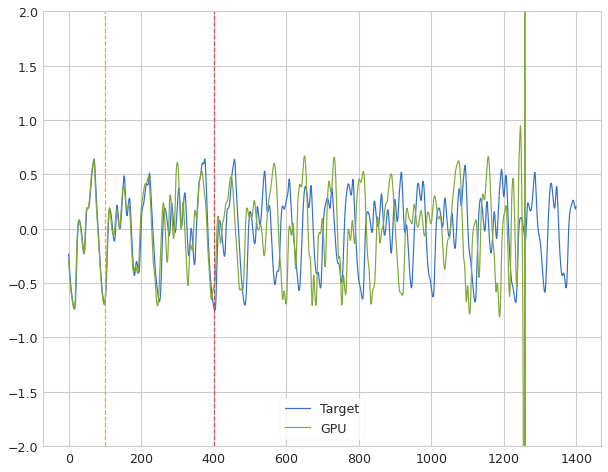

 Ref 0 Run 0 Iter=17 a=0.789 sr=5.574 amp=0.232  ri=0.454 rr=2.736 loss=0.262010


Iter: 17 #### Diagnostic 0.262   Time 7.02  Best 0.262 NRMSE 0.110 CD 0.152
Iter: 18 #### Diagnostic 0.550   Time 6.63  Best 0.262 NRMSE 0.172 CD 0.378
Iter: 19 #### Diagnostic 263.388   Time 6.60  Best 0.262 NRMSE 262.276 CD 1.113
Iter: 20 #### Diagnostic 1000.000   Time 6.66  Best 0.262 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1000.000   Time 7.00  Best 0.262 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 0.780   Time 7.03  Best 0.262 NRMSE 0.211 CD 0.569
Iter: 23 #### Diagnostic 1000.000   Time 6.66  Best 0.262 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000   Time 6.75  Best 0.262 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000   Time 6.64  Best 0.262 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000   Time 6.65  Best 0.262 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 0.371   Time 6.64  Best 0.262 NRMSE 0.136 CD 0.235
Iter: 28 #### Diagnostic 1000.000   Time 6.60  Best 0

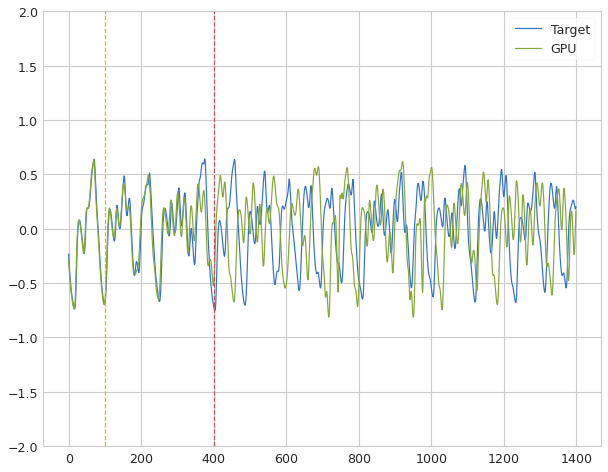

 Ref 0 Run 0 Iter=41 a=0.738 sr=5.511 amp=0.236  ri=0.513 rr=2.715 loss=0.201865


Iter: 41 #### Diagnostic 0.202   Time 6.97  Best 0.202 NRMSE 0.091 CD 0.111
Iter: 42 #### Diagnostic 0.865   Time 6.59  Best 0.202 NRMSE 0.224 CD 0.641
Iter: 43 #### Diagnostic 0.447   Time 6.66  Best 0.202 NRMSE 0.150 CD 0.297
Iter: 44 #### Diagnostic 1000.000   Time 13.31  Best 0.202 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000   Time 18.10  Best 0.202 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000   Time 15.48  Best 0.202 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 0.661   Time 12.88  Best 0.202 NRMSE 0.183 CD 0.478
Iter: 48 #### Diagnostic 1000.000   Time 8.55  Best 0.202 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000   Time 9.96  Best 0.202 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1000.000   Time 13.33  Best 0.202 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1000.000   Time 13.30  Best 0.202 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000   Time 13.29 

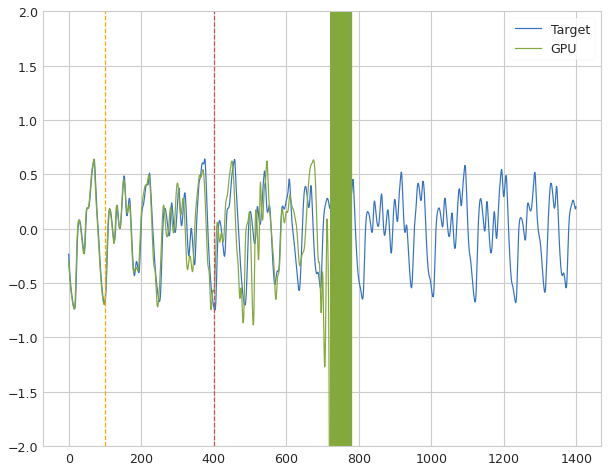

 Ref 0 Run 0 Iter=63 a=0.735 sr=5.558 amp=0.240  ri=0.467 rr=2.662 loss=0.197792


Iter: 63 #### Diagnostic 0.198   Time 15.43  Best 0.198 NRMSE 0.092 CD 0.105
Iter: 64 #### Diagnostic 1000.000   Time 15.31  Best 0.198 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1000.000   Time 7.85  Best 0.198 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 0.978   Time 6.81  Best 0.198 NRMSE 0.239 CD 0.739
Iter: 67 #### Diagnostic 1000.000   Time 7.59  Best 0.198 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000   Time 6.63  Best 0.198 NRMSE 11675133280754118656.000 CD 1.000
Iter: 69 #### Diagnostic 1000.000   Time 6.63  Best 0.198 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 0.572   Time 6.61  Best 0.198 NRMSE 0.172 CD 0.399
Iter: 71 #### Diagnostic 0.830   Time 6.61  Best 0.198 NRMSE 0.210 CD 0.621
Iter: 72 #### Diagnostic 1000.000   Time 6.60  Best 0.198 NRMSE 1000.000 CD nan


KeyboardInterrupt: 

In [5]:
CALLS = 100
s = torch.torch.from_numpy(signal).cuda(DEVICE).type(dtype)
size = np.flip(np.array([10,20,30,40,50,100,200,300,400,500,600,700,800,900,1000]))

rand_state = [11,37,3,24,91]

for N in sizes:
    min_a, max_a = .2,.8      # .2, .4
    min_sr, max_sr = 5,6.5    # 5., 6.5
    min_g, max_g = .2, .4     # .2, .4
    min_ri, max_ri = .4, .7   # .001, 5.
    min_rr, max_rr = 2, 3     # .001, 5.
    space = [Real(min_a, max_a, name='a'),
                     Real(min_sr, max_sr, name='sr'),
                     Real(min_g, max_g, name='amp'), 
                     Real(min_ri, max_ri, name='ri'),
                     Real(min_rr, max_rr, name='rr')
                    ]
    for ref in range(2):
        start = time.time()
        alphas = []
        rhos = []
        gammas = []
        inScales = []
        resScales = []

        for rn in range(1):
            running_error = 1000
            counter = 0 
            print(f'\n ********** {N} ***********')
            result_gp = gp_minimize(loop,
                                    space,
                                    n_calls=CALLS,
                                    random_state=rand_state[rn],
                                    n_jobs=-1,
                                    n_initial_points=100)
            print(f'\nBest result = {result_gp.fun}')
            names = ['a','sr','amp','ri','rr']
            for i in range(len(space)):
                print(f'{names[i]} = {result_gp.x[i]}')

        min_a, max_a   = resize_spaces(min_a, max_a,
                                       np.array(alphas),
                                       isAlpha=True)
        min_sr, max_sr = resize_spaces(min_sr, max_sr, np.array(rhos))
        min_g, max_g   = resize_spaces(min_g, max_g, np.array(gammas))
        min_ri, max_ri = resize_spaces(min_ri, max_ri, np.array(inScales))
        min_rr, max_rr = resize_spaces(min_rr, max_rr, np.array(resScales))
        print('Refined search bounds:\n')
        print(f'Alpha ({min_a}, {max_a})\n')
        print(f'Rho ({min_sr}, {max_sr})\n')
        print(f'Gamma ({min_g}, {max_g})\n')
        print(f'r-in ({min_ri}, {max_ri})\n')
        print(f'r-res ({min_rr}, {max_rr})\n')
        end = time.time()-start
        print(f'End Refinement Run {ref} Time {end:.3f}')